In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
from nltk.stem import PorterStemmer
import re
import string
#from sklearn.model_selection import GridSearchCV
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt_tab') ##

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
np.random.seed(500)

In [ ]:
Corpus = pd.read_csv('/content/sample_data/Datamail.csv', encoding='latin-1')
Corpus['Label'] = Corpus['Label'].astype(str)
print(Corpus['Label'].dtype)
print(Corpus['Label'].value_counts())
print(Corpus['Label'].isnull().sum())

not_recommended_samples = Corpus[Corpus['Label'] == '1'].sample(n=15000, random_state=42)
recommended_samples = Corpus[Corpus['Label'] == '0'].sample(n=15000, random_state=42)


Corpus = pd.concat([not_recommended_samples, recommended_samples])


Corpus = Corpus.sample(frac=1, random_state=42).reset_index(drop=True)


print(Corpus)


object
Label
ham     4825
spam     747
Name: count, dtype: int64
0


In [ ]:
#Convert text to lowercase
Corpus['Comment'] = [comment.lower() for comment in Corpus['Comment']]

#Remove numbers
Corpus['Comment'] = [re.sub(r'\d+', '', comment) for comment in Corpus['Comment']]

#Remove punctuation
translator = str.maketrans('', '', string.punctuation)  # Create a translation table
Corpus['Comment'] = [comment.translate(translator) for comment in Corpus['Comment']]

#White spaces removal
Corpus['Comment'] = [comment.strip() for comment in Corpus['Comment']]

#Tokenization
Corpus['Comment']= [word_tokenize(comment) for comment in Corpus['Comment']]

# Remove stop words and apply stemming
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
Corpus['Comment'] = [
    [stemmer.stem(token) for token in comment if token not in stop_words and token.isalpha()]
    for comment in Corpus['Comment']
]

# Join tokens back into a single string for TfidfVectorizer
Corpus['Comment'] = [' '.join(comment) for comment in Corpus['Comment']]

In [ ]:
#Corpus = Corpus[Corpus['text_final'].notnull()]
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['Comment'],Corpus['Label'],test_size=0.2)
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [ ]:
pip install wordcloud matplotlib pandas

     Label                                            Comment
0      ham  go jurong point crazi avail bugi n great world...
1      ham                              ok lar joke wif u oni
2     spam  free entri wkli comp win fa cup final tkt st m...
3      ham                u dun say earli hor u c alreadi say
4      ham          nah dont think goe usf live around though
...    ...                                                ...
5567  spam  nd time tri contact u u pound prize claim easi...
5568   ham                              b go esplanad fr home
5569   ham                            piti mood soani suggest
5570   ham  guy bitch act like id interest buy someth els ...
5571   ham                                     rofl true name

[5572 rows x 2 columns]


**Draw Top Word for SPAM and HAM respectively**



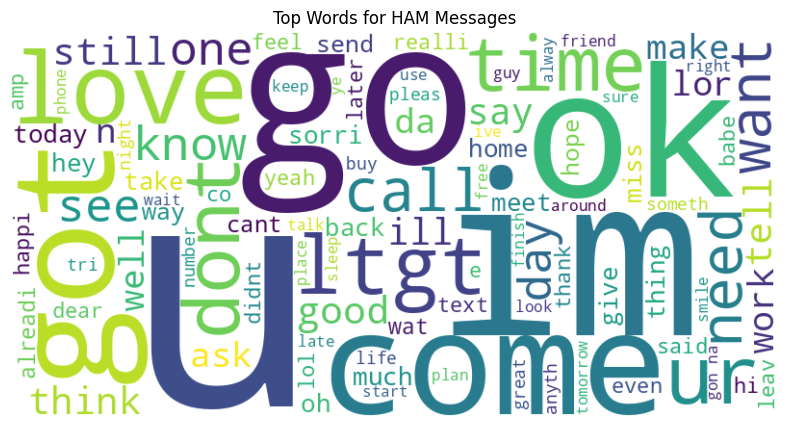

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter for HAM messages (assuming 0 is for HAM and 1 is for SPAM)
ham_messages = Corpus[Corpus['Label'] == 'ham']['Comment']

# Combine all HAM messages into a single string
ham_text = ' '.join(ham_messages)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, colormap='viridis').generate(ham_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Top Words for HAM Messages')
plt.show()

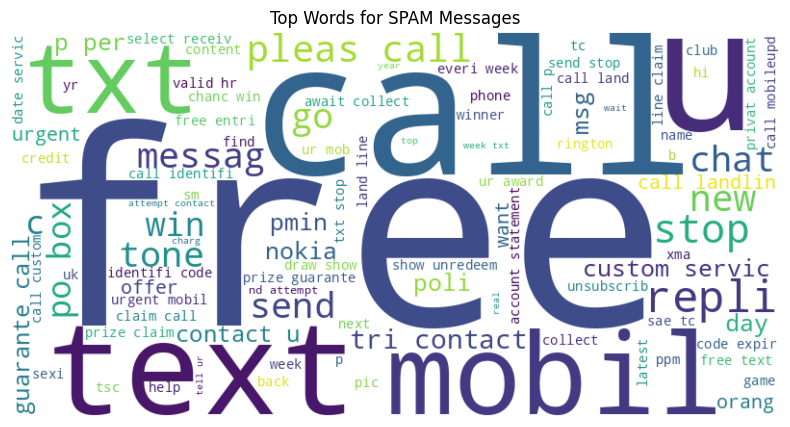

In [ ]:
# Filter for spam messages
spam_messages = Corpus[Corpus['Label'] == 'spam']['Comment']

# Combine all spam messages into a single string
spam_text = ' '.join(spam_messages)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, colormap='viridis').generate(spam_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Top Words for SPAM Messages')
plt.show()

**Get the sentiment rating for each Email text and convert it into a matrix**

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
nltk.download('vader_lexicon')


sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment scores
def get_sentiment_scores(comment):
    return sia.polarity_scores(comment)['compound']  # Extract compound score

# Create custom feature: sentiment scores
Train_X_sentiment = Train_X.apply(get_sentiment_scores)
Test_X_sentiment = Test_X.apply(get_sentiment_scores)

# Convert sentiment scores into a DataFrame and then to a sparse matrix
#Train_X_sentiment_df = pd.DataFrame(Train_X_sentiment, columns=['Sentiment'])
#Test_X_sentiment_df = pd.DataFrame(Test_X_sentiment, columns=['Sentiment'])
Train_X_sentiment_array = Train_X_sentiment.values.astype(float).reshape(-1, 1)  # Reshape to 2D
Test_X_sentiment_array = Test_X_sentiment.values.astype(float).reshape(-1, 1) # Reshape to 2D

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**The text data of each Email was converted into vector form and combined into sentiment rating for SVM learning**

In [ ]:
Tfidf_vect = TfidfVectorizer(max_features=8000)# ngram_range=(1, 2), min_df=2，max_features=8000,analyzer='word',strip_accents='unicode'
Tfidf_vect.fit(Corpus['Comment'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

# Combine TF-IDF features and Sentiment
Train_X_combined = hstack([Train_X_Tfidf, csr_matrix(Train_X_sentiment_array)])
Test_X_combined = hstack([Test_X_Tfidf, csr_matrix(Test_X_sentiment_array)])

In [ ]:
print("Train_X_Tfidf shape:", Train_X_Tfidf.shape)
print("Train_X_sentiment_array shape:", Train_X_sentiment_array.shape)
print("Test_X_Tfidf shape:", Test_X_Tfidf.shape)
print("Test_X_sentiment_array shape:", Test_X_sentiment_array.shape)
print("Train_X_combined shape:", Train_X_combined.shape)
print("Test_X_combined shape:", Test_X_combined.shape)

Train_X_Tfidf shape: (4457, 7120)
Train_X_sentiment_array shape: (4457, 1)
Test_X_Tfidf shape: (1115, 7120)
Test_X_sentiment_array shape: (1115, 1)
Train_X_combined shape: (4457, 7121)
Test_X_combined shape: (1115, 7121)


**Grid search was used to find the optimal parameters, and the Performance of the optimal solution Model on Trainset and Testset was obtained respectively**

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1, 1]
}

SVM = svm.SVC(kernel='linear',class_weight='balanced',probability=True)
grid_search = GridSearchCV(SVM, param_grid, scoring='roc_auc', cv=5, refit=True)
grid_search.fit(Train_X_combined, Train_Y)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters: ", best_params)

predictions_SVM1 = best_model.predict(Test_X_combined)
predictions_SVM2 = best_model.predict(Train_X_combined)
# Use accuracy_score function to get the accuracy
print("SVM Tesing Accuracy Score -> ",accuracy_score(predictions_SVM1, Test_Y)*100)
print("SVM Training Accuracy Score -> ",accuracy_score(predictions_SVM2, Train_Y)*100)

Best Parameters:  {'C': 1, 'gamma': 'scale'}
SVM Tesing Accuracy Score ->  98.20627802690582
SVM Training Accuracy Score ->  99.798070450976


In [ ]:
print(grid_search.best_score_)

0.9782367773399162


In [ ]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1, kernel='linear', gamma='scale',class_weight='balanced', probability=True)
SVM.fit(Train_X_combined,Train_Y)
# predict the labels on validation dataset
predictions_SVM3 = SVM.predict(Test_X_combined)
predictions_SVM4 = SVM.predict(Train_X_combined)
# Use accuracy_score function to get the accuracy
print("SVM Tesing Accuracy Score -> ",accuracy_score(predictions_SVM3, Test_Y)*100)
print("SVM Training Accuracy Score -> ",accuracy_score(predictions_SVM4, Train_Y)*100)

SVM Tesing Accuracy Score ->  98.20627802690582
SVM Training Accuracy Score ->  99.798070450976


In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

In [ ]:
print("Tetsing1 Performance \n-------------------------------------------------------")

print(classification_report(Test_Y, predictions_SVM1, target_names=['Class 0', 'Class 1']))

print("\nTrianing Performance \n-------------------------------------------------------")

print(classification_report(Train_Y, predictions_SVM2, target_names=['Class 0', 'Class 1']))


Tetsing1 Performance 
-------------------------------------------------------
              precision    recall  f1-score   support

     Class 0       0.98      0.99      0.99       967
     Class 1       0.96      0.90      0.93       148

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115


Trianing Performance 
-------------------------------------------------------
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      3858
     Class 1       0.99      1.00      0.99       599

    accuracy                           1.00      4457
   macro avg       0.99      1.00      1.00      4457
weighted avg       1.00      1.00      1.00      4457



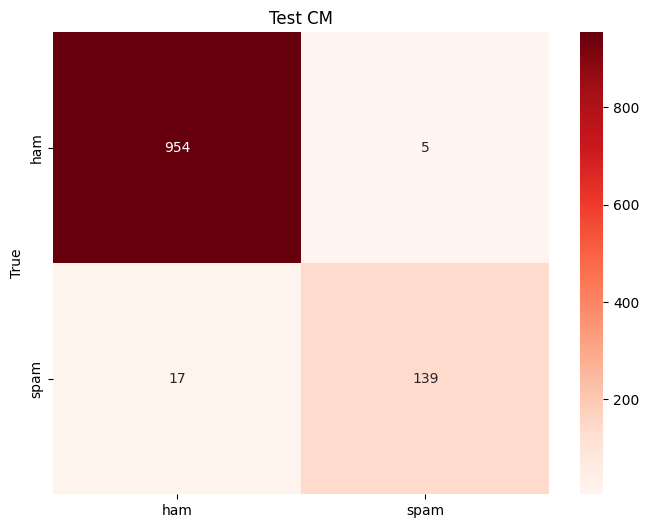

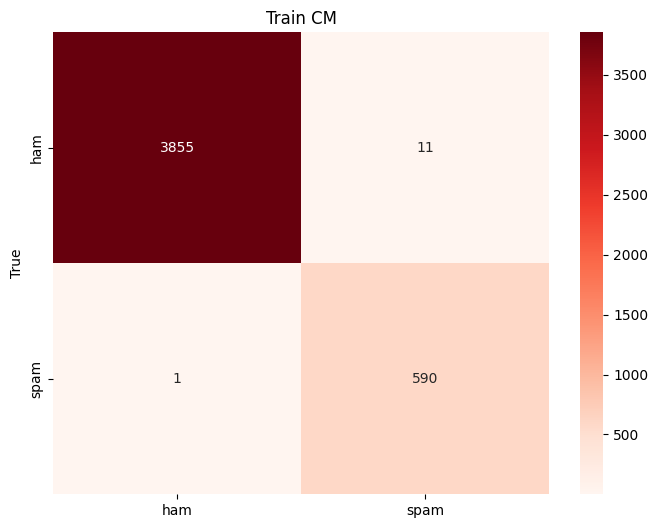

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm1 = confusion_matrix(Test_Y, predictions_SVM1)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='g', cmap='Reds', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
#plt.xlabel('Predicted')
#plt.ylabel('True')
plt.title('Test CM')
plt.show()

# Compute confusion matrix
cm2 = confusion_matrix(Train_Y, predictions_SVM2)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='g', cmap='Reds', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
#plt.xlabel('Predicted')
#plt.ylabel('True')
plt.title('Train CM')
plt.show()

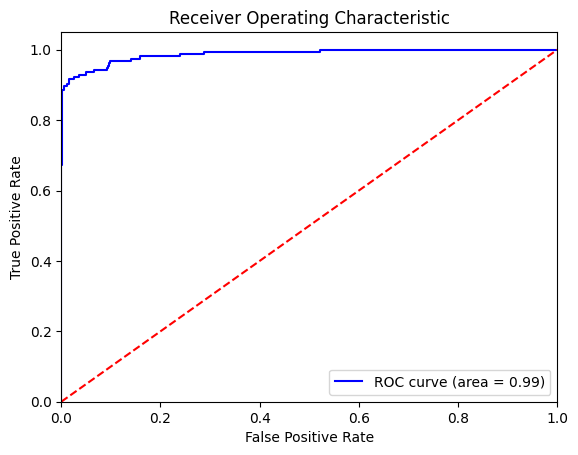

In [ ]:
y_pred_proba = SVM.predict_proba(Test_X_combined)[:, 1]

fpr, tpr, thresholds = roc_curve(Test_Y, y_pred_proba)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.svm import LinearSVC

SVM = svm.LinearSVC(C=1.0, max_iter=2000, tol=0.01, loss='squared_hinge', penalty='l1', class_weight='balanced')
SVM.fit(Train_X_combined,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_combined)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  97.39910313901345


In [ ]:
from textblob import TextBlob
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
nltk.download('brown')

def extract_features(comment):
    blob = TextBlob(comment)
    pos_tags = blob.tags  # POS tagging
    noun_phrases = blob.noun_phrases  # Extract noun phrases
    pos_counts = pd.Series(dict(pos_tags)).value_counts()  # Count POS tags
    return pd.Series({
        'noun_phrase_count': len(noun_phrases),
        **pos_counts
    })
# Create POS feature DataFrames
Train_X_pos = Train_X.apply(extract_features)
Test_X_pos = Test_X.apply(extract_features)

# Fill NaN values with 0 for missing POS tags
Train_X_pos = Train_X_pos.fillna(0)
Test_X_pos = Test_X_pos.fillna(0)

# Convert POS DataFrames to NumPy arrays and ensure they are 2D
Train_X_pos_array = csr_matrix(Train_X_pos.values)
Test_X_pos_array = csr_matrix(Test_X_pos.values)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [ ]:
print(len(Tfidf_vect.vocabulary_))
print("Train_X_Tfidf shape:", Train_X_Tfidf.shape)
print("Train_X_pos_array shape:", Train_X_pos_array.shape)
print("Test_X_Tfidf shape:", Test_X_Tfidf.shape)
print("Test_X_pos_array shape:", Test_X_pos_array.shape)
print("Test_X_pos_array shape:", Test_X_pos_array.shape)

15000
Train_X_Tfidf shape: (24000, 15000)
Train_X_pos_array shape: (24000, 34)
Test_X_Tfidf shape: (6000, 15000)
Test_X_pos_array shape: (6000, 34)
Test_X_pos_array shape: (6000, 34)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

# Define the model
model = LinearSVC()

# Define the parameter grid to search, including penalty and loss
param_grid = {
    'C': [1, 10, 100],          # Regularization parameter
    'max_iter': [800,1000,2000,3000],           # Maximum number of iterations
    'tol': [1e-6,1e-5,1e-4,1e-3, 1e-2],              # Tolerance for stopping criteria
    'penalty': ['l2','l1'],                # Regularization type 'l1'
    'loss': ['squared_hinge'],
    'class_weight':['balanced'] # Loss function , 'squared_hinge','hinge',
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Fit the model
grid_search.fit(Train_X_combined, Train_Y)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

# Use the best estimator to make predictions
best_model = grid_search.best_estimator_
predictions = best_model.predict(Test_X_combined)

# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(Test_Y, predictions))
print("Accuracy Score:", accuracy_score(Test_Y, predictions)*100)

Best Parameters: {'C': 1, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'max_iter': 800, 'penalty': 'l2', 'tol': 1e-06}
Best Cross-Validation Score: 0.9793565953506164
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       959
           1       0.97      0.88      0.92       156

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy Score: 97.9372197309417
